In [1]:
pip install tensorflow

     -------------------------------------- 266.3/266.3 MB 7.0 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 12.0 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 11.8 MB/s eta 0:00:00
     ---------------------------------------- 3.7/3.7 MB 11.4 MB/s eta 0:00:00
     --------------------------------------- 23.2/23.2 MB 11.3 MB/s eta 0:00:00
     -------------------------------------- 126.5/126.5 kB 7.8 MB/s eta 0:00:00
     ---------------------------------------- 65.5/65.5 kB 3.7 MB/s eta 0:00:00
     -------------------------------------- 439.2/439.2 kB 9.1 MB/s eta 0:00:00
     ---------------------------------------- 6.0/6.0 MB 11.3 MB/s eta 0:00:00
     ---------------------------------------- 57.5/57.5 kB 3.1 MB/s eta 0:00:00
     ------------------------------------- 895.9/895.9 kB 11.4 MB/s eta 0:00:00
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-

In [2]:
pip install -U scikit-learn

     ---------------------------------------- 8.4/8.4 MB 10.7 MB/s eta 0:00:00
     ------------------------------------- 298.0/298.0 kB 19.2 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
Note: you may need to restart the kernel to use updated packages.


In [29]:
import os
import numpy as np
from collections import defaultdict

def encode_one_hot(train_set, classes="AGCT"):
    encoder = defaultdict(lambda: np.array([0]*len(classes)))
    
    for i, _class in enumerate(classes):
        tmp = np.zeros(len(classes))
        tmp[i] = 1
        encoder[_class] = tmp
    output = []
    for record in train_set:
        encoded_record = []
        
        for c in record:
            encoded_record.append(encoder[c])
        
        output.append(encoded_record)
    
    output = np.array(output)
    
    return output

In [30]:
import gzip
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# single dataset version
def get_dataset(path):
    dataset = gzip.open(path, "r")
    output = []
    for i, record in tqdm(enumerate(dataset)):
        record = record.decode()
        record = record[:-1]
        record = record.split('\t')
        if i != 0:
            output.append(record)
    output = np.array(output).reshape([-1, 4])
    print(np.array(output[:, 3]))
    print(np.array(output[:, 3]).flatten())
    return encode_one_hot(output[:, 2]), np.array(output[:, 3]).flatten()

x, y = get_dataset("./dataset_mini.gz")
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.33, random_state=112)

del(x, y)

print(train_x.shape)
print(train_y.shape)

print(test_x.shape)
print(test_y.shape)

50001it [00:00, 1071505.76it/s]


['1' '0' '1' ... '0' '1' '0']
['1' '0' '1' ... '0' '1' '0']
(33500, 20, 4)
(33500,)
(16500, 20, 4)
(16500,)


In [31]:
from tensorflow.keras.utils import to_categorical

train_x = train_x.reshape(-1, 80)
test_x = test_x.reshape(-1, 80)

train_y = to_categorical(train_y, 2)
test_y = to_categorical(test_y, 2)

print("Train Set | x:", train_x.shape, ", y:", train_y.shape)
print("Valid Set | x:", test_x.shape, ", y:", test_y.shape)

Train Set | x: (33500, 80) , y: (33500, 2)
Valid Set | x: (16500, 80) , y: (16500, 2)


In [32]:
import tensorflow as tf
from tensorflow.keras import layers

def MLP_model(unit, hidden, input_shape):
  model = tf.keras.Sequential()

  model.add(layers.Dense(units=unit, input_dim=input_shape, activation='relu'))

  for i in range(1, hidden + 1):
    model.add(layers.Dense(units=unit, kernel_initializer='glorot_uniform', activation='relu'))
  
  model.add(layers.Dense(units=2, kernel_initializer='glorot_uniform', activation='softmax'))

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [33]:
model = MLP_model(unit=20, hidden=3, input_shape=train_x.shape[1])
history = model.fit(train_x, train_y, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
838/838 [==============================] - 1s 815us/step - loss: 0.5575 - accuracy: 0.7004 - val_loss: 0.4531 - val_accuracy: 0.7890
Epoch 2/10
838/838 [==============================] - 1s 713us/step - loss: 0.4230 - accuracy: 0.8079 - val_loss: 0.4277 - val_accuracy: 0.8057
Epoch 3/10
838/838 [==============================] - 1s 711us/step - loss: 0.3833 - accuracy: 0.8313 - val_loss: 0.3851 - val_accuracy: 0.8309
Epoch 4/10
838/838 [==============================] - 1s 713us/step - loss: 0.3603 - accuracy: 0.8426 - val_loss: 0.3691 - val_accuracy: 0.8385
Epoch 5/10
838/838 [==============================] - 1s 711us/step - loss: 0.3425 - accuracy: 0.8516 - val_loss: 0.3699 - val_accuracy: 0.8351
Epoch 6/10
838/838 [==============================] - 1s 707us/step - loss: 0.3299 - accuracy: 0.8572 - val_loss: 0.3565 - val_accuracy: 0.8445
Epoch 7/10
838/838 [==============================] - 1s 726us/step - loss: 0.3194 - accuracy: 0.8638 - val_loss: 0.3494 - val_accuracy:

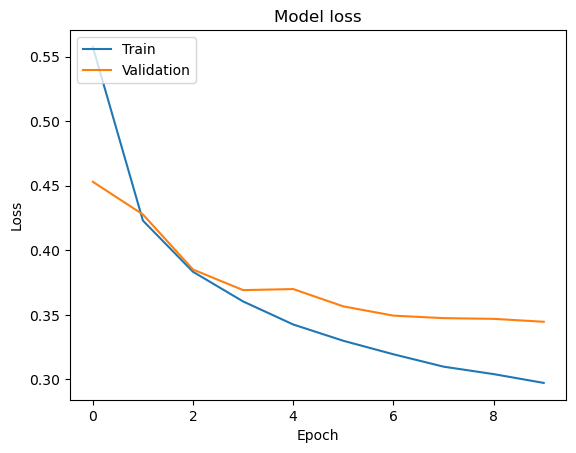

In [34]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

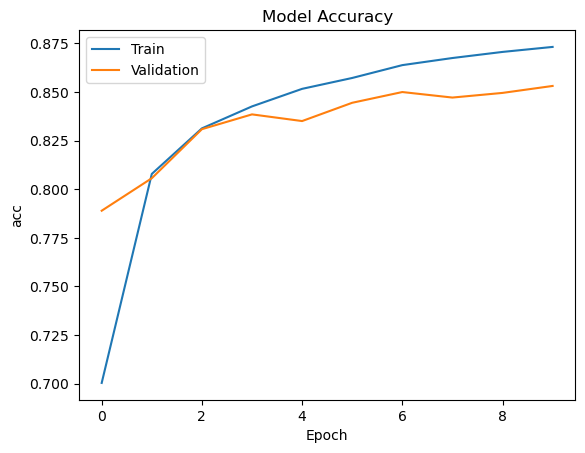

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [36]:
score = model.evaluate(test_x, test_y)
print('test loss:', score[1])

516/516 [==============================] - 0s 483us/step - loss: 0.3394 - accuracy: 0.8576
test loss: 0.8575757741928101


In [37]:
history = model.fit(train_x, train_y, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
838/838 [==============================] - 1s 777us/step - loss: 0.2927 - accuracy: 0.8761 - val_loss: 0.3465 - val_accuracy: 0.8518
Epoch 2/10
838/838 [==============================] - 1s 740us/step - loss: 0.2880 - accuracy: 0.8766 - val_loss: 0.3367 - val_accuracy: 0.8572
Epoch 3/10
838/838 [==============================] - 1s 745us/step - loss: 0.2871 - accuracy: 0.8788 - val_loss: 0.3389 - val_accuracy: 0.8555
Epoch 4/10
838/838 [==============================] - 1s 741us/step - loss: 0.2844 - accuracy: 0.8800 - val_loss: 0.3349 - val_accuracy: 0.8579
Epoch 5/10
838/838 [==============================] - 1s 750us/step - loss: 0.2801 - accuracy: 0.8810 - val_loss: 0.3422 - val_accuracy: 0.8581
Epoch 6/10
838/838 [==============================] - 1s 723us/step - loss: 0.2767 - accuracy: 0.8842 - val_loss: 0.3330 - val_accuracy: 0.8569
Epoch 7/10
838/838 [==============================] - 1s 719us/step - loss: 0.2744 - accuracy: 0.8847 - val_loss: 0.3398 - val_accuracy:

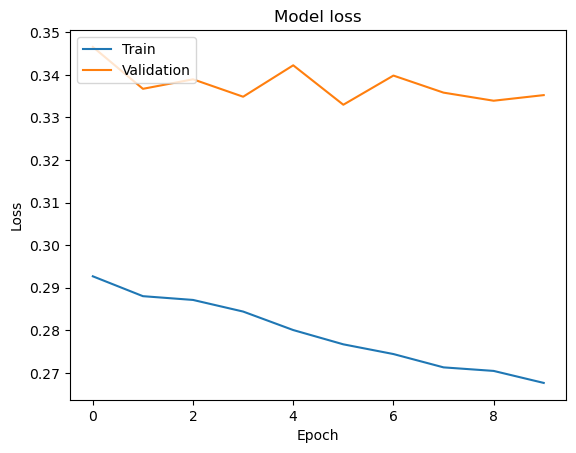

In [38]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

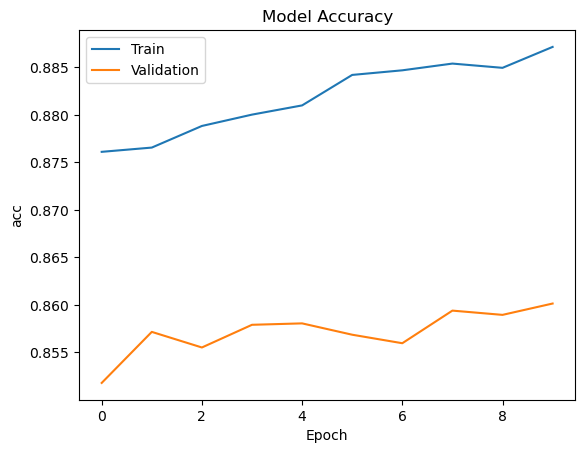

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [40]:
score = model.evaluate(test_x, test_y)
print('test loss:', score[1])

516/516 [==============================] - 0s 584us/step - loss: 0.3338 - accuracy: 0.8588
test loss: 0.8587878942489624
